# 1. Importing

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import pickle
import warnings
warnings.simplefilter('ignore')


# 2. Filter the data

In [2]:
qustions = pd.read_csv("Questions.csv", encoding='ISO-8859-1')
tags = pd.read_csv("Tags.csv", encoding='ISO-8859-1')
print(f"qustions shape is {qustions.shape}")
print(f"tags shape is {tags.shape}")

qustions shape is (1264216, 7)
tags shape is (3750994, 2)


In [3]:
qustions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [4]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [5]:
tags = tags.groupby('Id')['Tag'].apply(lambda x: ' '.join(x.astype(str)))
tags.reset_index()
tags = pd.DataFrame({'Id': tags.index, 'Tags': tags.values})
print(f"qustions shape is {qustions.shape}")
print(f"tags shape is {tags.shape}")
tags.head()

qustions shape is (1264216, 7)
tags shape is (1264216, 2)


,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [6]:
qustions = qustions[qustions['Score'] > 5]
qustions.drop(columns=["OwnerUserId", "CreationDate", "ClosedDate", "Score"], axis=1, inplace=True)
print(f"The shape of qustions : {qustions.shape}")
qustions.head()

The shape of qus : (72950, 3)


,Id,Title,Body
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [7]:
qustions_with_tagging = pd.merge(qustions, tags, on="Id")

In [8]:
import nltk
qustions_with_tagging['Tags'] = qustions_with_tagging['Tags'].apply(lambda x: x.split())
freq_list = []
for lst in  qustions_with_tagging['Tags'].values:
    for tag in lst:
        freq_list.append(tag)
count_freq = nltk.FreqDist(freq_list) 
most_common = [tag[0] for tag in count_freq.most_common(50)]

In [9]:
def keep_most_common(tags):
    tags_filtered = []
    for i in range(len(tags)):
        if tags[i] in most_common:
            tags_filtered.append(tags[i])
    return tags_filtered


qustions_with_tagging['Tags'] = qustions_with_tagging['Tags'].apply(lambda x: keep_most_common(x))
qustions_with_tagging['Tags'] = qustions_with_tagging['Tags'].apply(lambda x: x if len(x) > 0 else None)
qustions_with_tagging.dropna(subset=['Tags'], inplace=True)
qustions_with_tagging['Tags'] = qustions_with_tagging['Tags'].apply(lambda x: ' '.join(map(str, x)))
print(qustions_with_tagging.shape)
qustions_with_tagging.head()

(58872, 4)


,Id,Title,Body,Tags
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net
5,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++
6,470,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net


In [10]:

qustions_with_tagging = qustions_with_tagging.sample(30000, random_state=42)
print(qustions_with_tagging.shape)
qustions_with_tagging.head()

(30000, 4)


,Id,Title,Body,Tags
62503,23719990,Select N random elements from a List efficient...,"<p>As in the title, I want to use Knuth-Fisher...",java algorithm
7980,1487310,mysql too many columns?,<p>I'm creating a table with 30-50 columns. T...,sql mysql
66514,28491190,"MVC5 with VB.NET: ""BC30451: 'ViewData' is not ...",<p>I have a MVC5 project that is currently set...,asp.net-mvc
9604,1868210,How to log the memory consumption on Linux?,<p>Is there any ready-to-use solution to log t...,linux
66880,29033580,How do I use the new haskell-ng infrastructure...,<p>How do I setup a simple Haskell development...,haskell


## 2.1 Save the result to deal with it

In [11]:
qustions_with_tagging.to_csv("qustions_tagging_data.csv")

# 3. Data preprossing

In [2]:
qustions_with_tagging = pd.read_csv("qustions_tagging_data.csv")
print("The shape is: ", qustions_with_tagging.shape)
qustions_with_tagging.info()

The shape is:  (30000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   Id          30000 non-null  int64 
 2   Title       30000 non-null  object
 3   Body        30000 non-null  object
 4   Tags        30000 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [3]:
qustions_with_tagging.head()

,Unnamed: 0,Id,Title,Body,Tags
0,62503,23719990,Select N random elements from a List efficient...,"<p>As in the title, I want to use Knuth-Fisher...",java algorithm
1,7980,1487310,mysql too many columns?,<p>I'm creating a table with 30-50 columns. T...,sql mysql
2,66514,28491190,"MVC5 with VB.NET: ""BC30451: 'ViewData' is not ...",<p>I have a MVC5 project that is currently set...,asp.net-mvc
3,9604,1868210,How to log the memory consumption on Linux?,<p>Is there any ready-to-use solution to log t...,linux
4,66880,29033580,How do I use the new haskell-ng infrastructure...,<p>How do I setup a simple Haskell development...,haskell


In [4]:
qustions_with_tagging.drop(columns=["Unnamed: 0", "Id"], axis=1, inplace=True)
qustions_with_tagging.head()

,Title,Body,Tags
0,Select N random elements from a List efficient...,"<p>As in the title, I want to use Knuth-Fisher...",java algorithm
1,mysql too many columns?,<p>I'm creating a table with 30-50 columns. T...,sql mysql
2,"MVC5 with VB.NET: ""BC30451: 'ViewData' is not ...",<p>I have a MVC5 project that is currently set...,asp.net-mvc
3,How to log the memory consumption on Linux?,<p>Is there any ready-to-use solution to log t...,linux
4,How do I use the new haskell-ng infrastructure...,<p>How do I setup a simple Haskell development...,haskell


In [5]:
qustions_with_tagging.isnull().sum()

Title    0
Body     0
Tags     0
dtype: int64

In [6]:
qustions_with_tagging['Tags'] = qustions_with_tagging['Tags'].apply(lambda x: x.split())
qustions_with_tagging.head()

,Title,Body,Tags
0,Select N random elements from a List efficient...,"<p>As in the title, I want to use Knuth-Fisher...","[java, algorithm]"
1,mysql too many columns?,<p>I'm creating a table with 30-50 columns. T...,"[sql, mysql]"
2,"MVC5 with VB.NET: ""BC30451: 'ViewData' is not ...",<p>I have a MVC5 project that is currently set...,[asp.net-mvc]
3,How to log the memory consumption on Linux?,<p>Is there any ready-to-use solution to log t...,[linux]
4,How do I use the new haskell-ng infrastructure...,<p>How do I setup a simple Haskell development...,[haskell]


In [7]:
def text_cleaning(text, Stemmer = PorterStemmer()):
    # extract the text
    text = BeautifulSoup(text).get_text()
    
    # remove stop words and punctuation
    text = text.lower()
    words = word_tokenize(text) 
    stop_words = set(stopwords.words("english")).union(set(string.punctuation))
    filtered_list = [word for word in words if word.casefold() not in stop_words]
    
    # word stemming
    stemmer = Stemmer
    filtered_words = [word for word in filtered_list if not re.search(r'[^a-zA-Z]', word)]
    stem_words = [stemmer.stem(word) for word in filtered_words]
    
    return ' '.join(map(str, stem_words))


qustions_with_tagging['Body'] = qustions_with_tagging['Body'].apply(
    lambda text: text_cleaning(text))
qustions_with_tagging['Title'] = qustions_with_tagging['Title'].apply(
    lambda text: text_cleaning(text))
qustions_with_tagging.head()


,Title,Body,Tags
0,select n random element list effici without to...,titl want use shuffl algorithm select n random...,"[java, algorithm]"
1,mysql mani column,creat tabl column row recommend store data sep...,"[sql, mysql]"
2,declar switch debug configur,project current set releas configur work howev...,[asp.net-mvc]
3,log memori consumpt linux,solut log memori consumpt start system like lo...,[linux]
4,use new infrastructur nixo,setup simpl haskel develop environ nixo use ne...,[haskell]


# 4. Feature Extraction

In [8]:
tfidf_vectorizer_body = TfidfVectorizer(analyzer = 'word', max_features=3000)
tfidf_vectorizer_body.fit(qustions_with_tagging['Body'])
X1 = tfidf_vectorizer_body.transform(qustions_with_tagging['Body'])

terms = tfidf_vectorizer_body.get_feature_names()
X1_print = pd.DataFrame(X1.toarray(), columns=terms)
print(X1_print.shape)
X1_print.head()


(30000, 3000)


,aa,ab,abandon,abc,abil,abl,abort,absolut,abstract,abstractclass,...,year,yellow,yesterday,yet,yield,youtub,zero,zip,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.118567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
tfidf_vectorizer_title = TfidfVectorizer(analyzer='word', max_features=3000)
tfidf_vectorizer_title.fit(qustions_with_tagging['Title'])
X2 = tfidf_vectorizer_title.transform(qustions_with_tagging['Title'])

terms = tfidf_vectorizer_title.get_feature_names()
X2_print = pd.DataFrame(X2.toarray(), columns=terms)
print(X2_print.shape)
X2_print.head()


(30000, 3000)


,abandon,abl,abort,absolut,abstract,acceler,acceleromet,accent,accept,access,...,yosemit,youtub,zend,zero,zip,zlib,zombi,zone,zoom,zsh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from scipy.sparse import hstack
X = hstack([X1, X2])
X.shape

(30000, 6000)

In [11]:

multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(qustions_with_tagging['Tags'])
print(Y.shape)
Y

(30000, 50)


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# 5. Model Training

In [12]:
X_train, _x, y_train, _y = train_test_split(X, Y, test_size=0.33333, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(_x, _y, test_size=0.5, random_state=42)
del _x, _y
print(f"X_Train shape is: {X_train.shape}")
print(f"X_Test shape is: {X_test.shape}")
print(f"X_val shape is: {X_val.shape}")
print(f"Y_Train shape is: {y_train.shape}")
print(f"Y_Test shape is: {y_test.shape}")
print(f"Y_val shape is: {y_val.shape}")

X_Train shape is: (20000, 6000)
X_Test shape is: (5000, 6000)
X_val shape is: (5000, 6000)
Y_Train shape is: (20000, 50)
Y_Test shape is: (5000, 50)
Y_val shape is: (5000, 50)


In [13]:
def hamming_loss(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.not_equal(y_true, tf.round(y_pred)), dtype=tf.float32))


In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=700, activation='relu',
                          input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=500, activation='relu'),
    tf.keras.layers.Dense(units=300, activation='relu'),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dense(units=150, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[hamming_loss, 'accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[
          early_stop])  # loss: 0.0071 - hamming_loss: 0.0024 - accuracy: 0.8084


Epoch 1/20
625/625 [==============================] - 57s 88ms/step - loss: 0.1081 - hamming_loss: 0.0281 - accuracy: 0.2794 - val_loss: 0.0678 - val_hamming_loss: 0.0213 - val_accuracy: 0.4996
Epoch 2/20
625/625 [==============================] - 55s 88ms/step - loss: 0.0542 - hamming_loss: 0.0178 - accuracy: 0.6023 - val_loss: 0.0590 - val_hamming_loss: 0.0183 - val_accuracy: 0.5838
Epoch 3/20
625/625 [==============================] - 55s 88ms/step - loss: 0.0343 - hamming_loss: 0.0121 - accuracy: 0.7107 - val_loss: 0.0633 - val_hamming_loss: 0.0191 - val_accuracy: 0.5694
Epoch 4/20
625/625 [==============================] - 55s 88ms/step - loss: 0.0211 - hamming_loss: 0.0078 - accuracy: 0.7638 - val_loss: 0.0750 - val_hamming_loss: 0.0197 - val_accuracy: 0.5708
Epoch 5/20
625/625 [==============================] - 56s 89ms/step - loss: 0.0137 - hamming_loss: 0.0049 - accuracy: 0.7891 - val_loss: 0.0910 - val_hamming_loss: 0.0205 - val_accuracy: 0.5608
Epoch 6/20
625/625 [==========

In [25]:
# Pickle the model to not train it again
file = open("nueral_network_model.obj", "wb")
pickle.dump(model, file)
file.close()

In [14]:
file = open("nueral_network_model.obj", "rb")
model = pickle.load(file)
file.close()

# loss: 0.1165 - hamming_loss: 0.0206 - accuracy: 0.5658
model.evaluate(X_test, y_test)


157/157 [==============================] - 2s 10ms/step - loss: 0.1165 - hamming_loss: 0.0206 - accuracy: 0.5658


[0.11650904268026352, 0.02059713378548622, 0.5658000111579895]

157/157 [==============================] - 1s 7ms/step


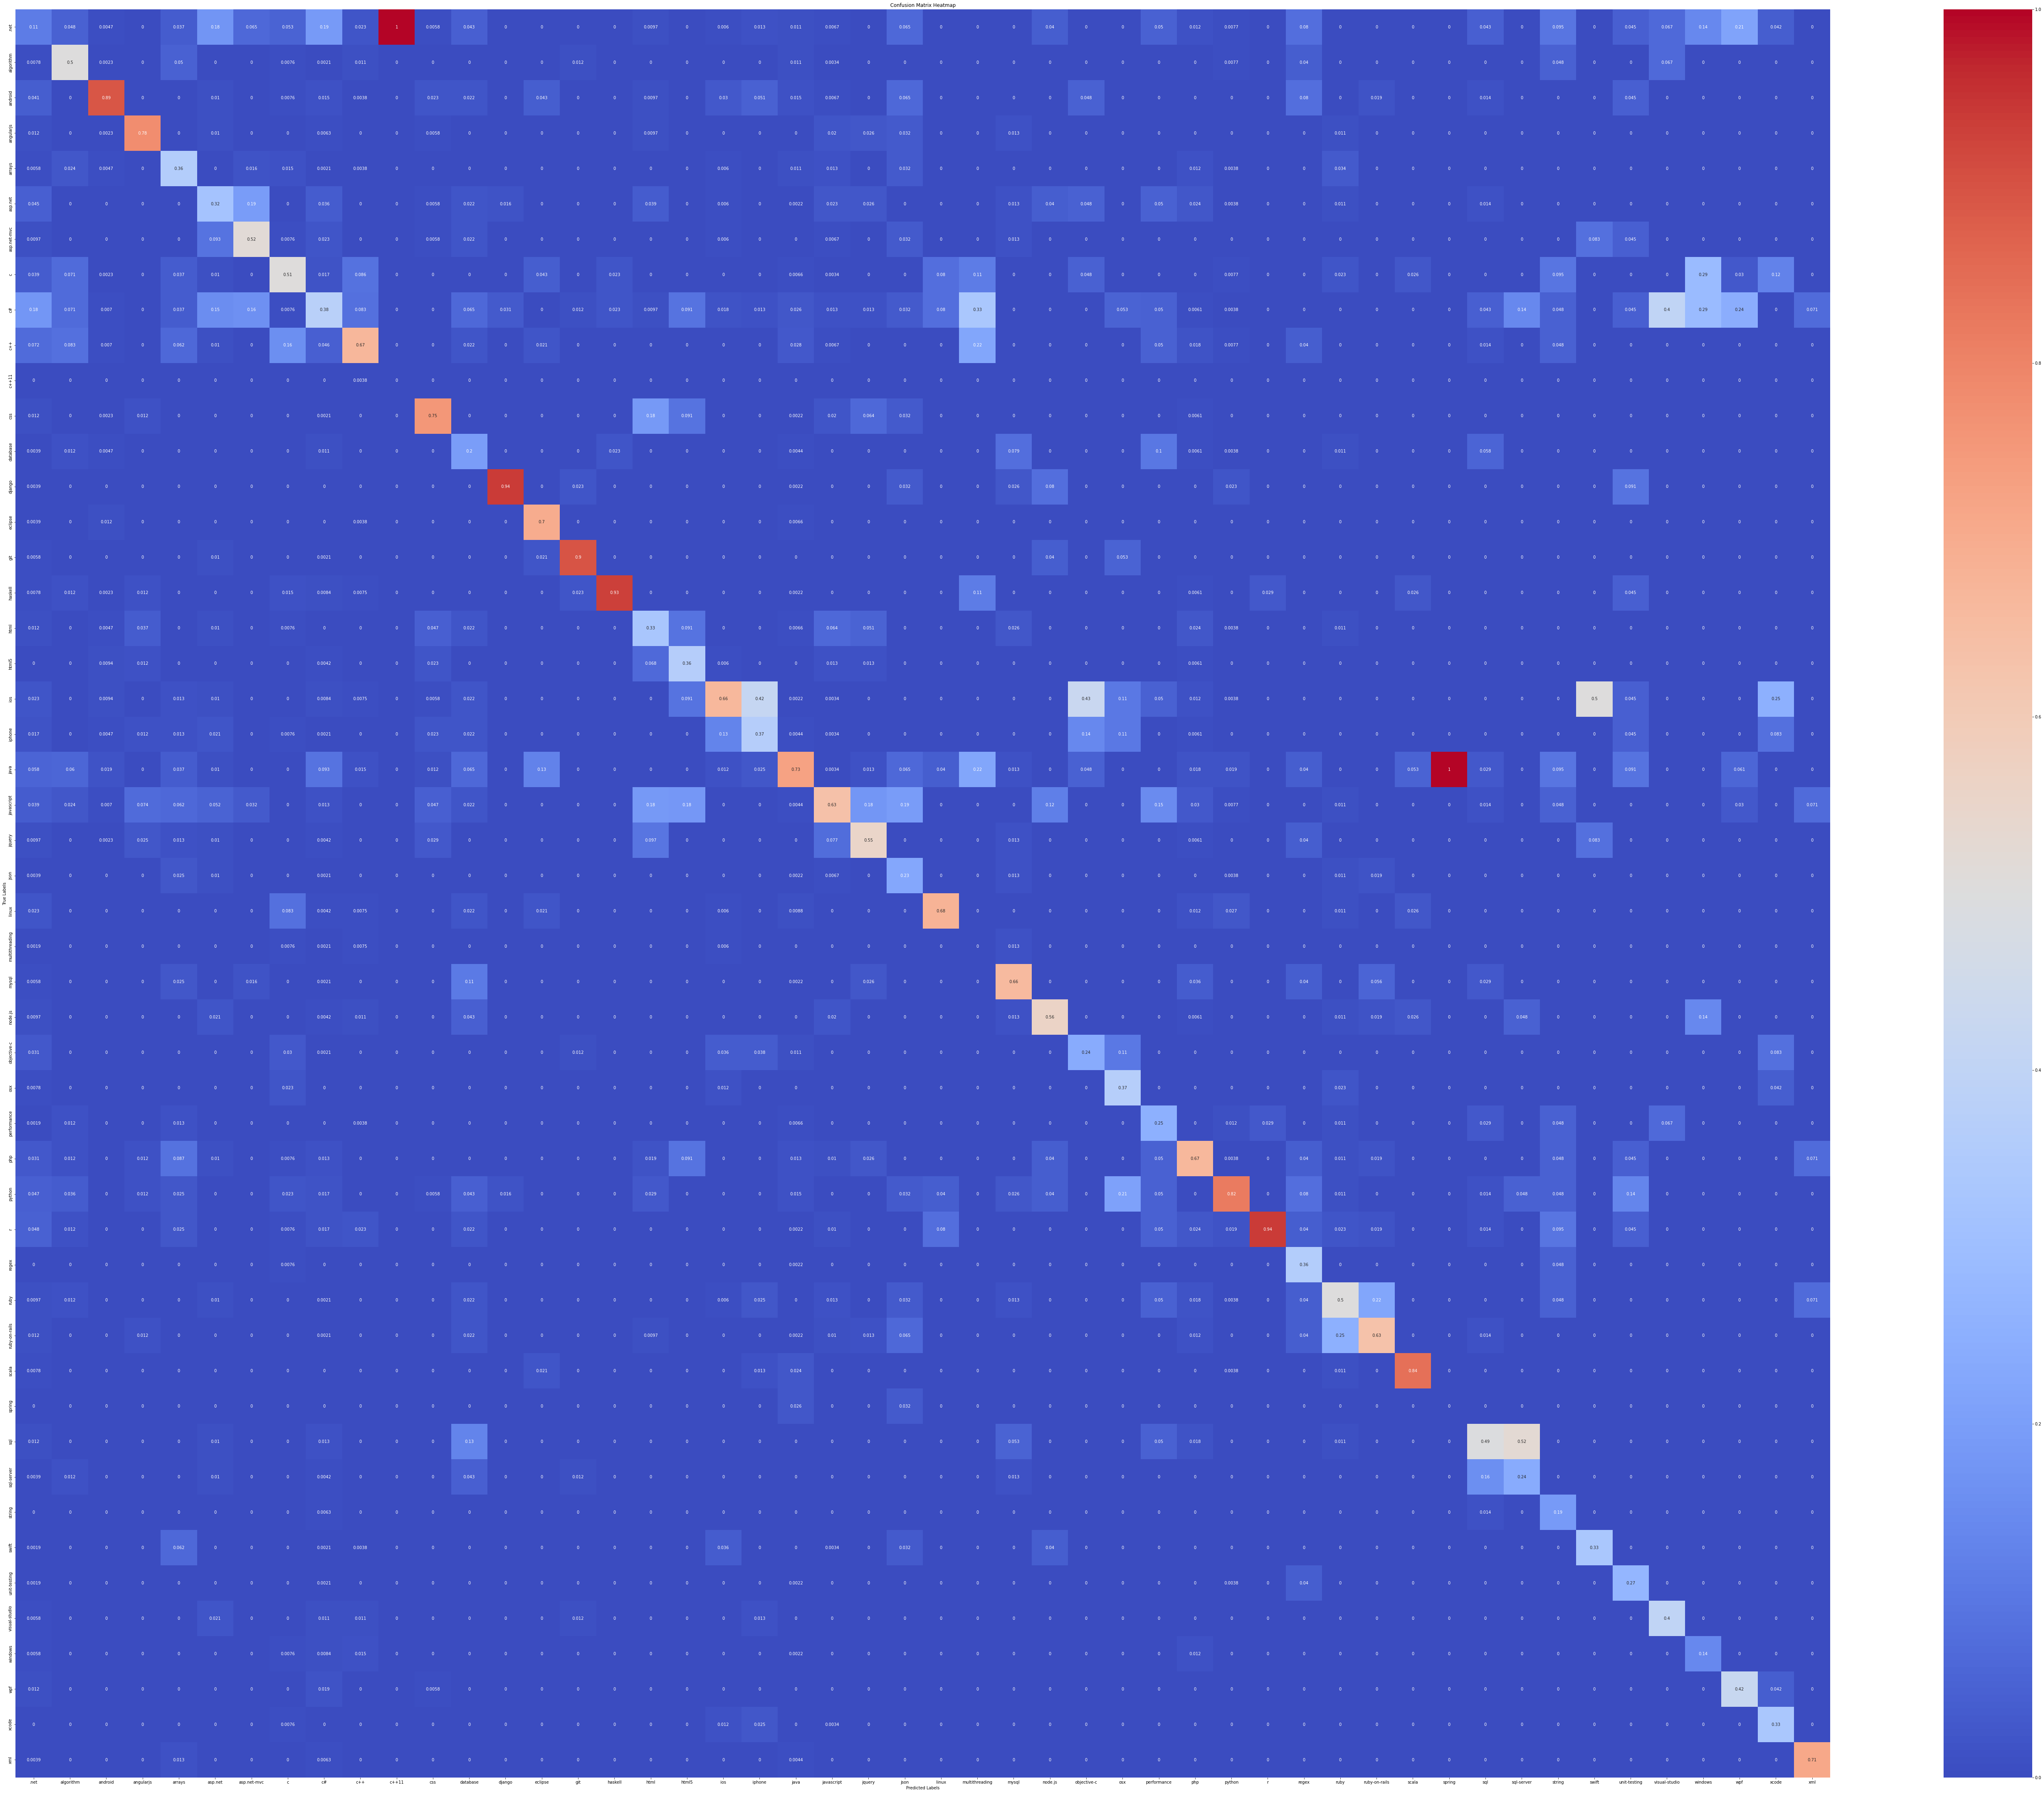

In [15]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred)
label_names = list(multilabel_binarizer.classes_)

confusion_matrix = tf.math.confusion_matrix(
    labels=y_test.argmax(axis=1),
    predictions=y_pred_binary.argmax(axis=1)).numpy()

confusion_matrix_norm = confusion_matrix / confusion_matrix.sum(axis=0)


plt.figure(figsize=(100, 80))
sns.heatmap(
    confusion_matrix_norm,
    cmap="coolwarm",
    annot=True,
    xticklabels=label_names,
    yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
